In [2]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
import optuna
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate
import pickle

pd.set_option('display.max_columns', None)
print('alt.renderers:', alt.renderers.enable('colab'))
print('optuna.__version__:', optuna.__version__)
RANDOM_STATE=123

alt.renderers: RendererRegistry.enable('colab')
optuna.__version__: 2.10.1


In [18]:
# Google Colab Mount Drives
# Note: Need to 'Add as Shortcut' in personal drive if accesing via 'Shared with me' drive (https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab)
#from google.colab import drive
#drive.mount('/content/drive')

# List directories on drive
#!ls "/content/drive/My Drive/Capstone"

# 1) Merge & Process Shipping.xlsx to ReviewEmotion.xlsx

## Load & Process ReviewEmotion.xlsx

In [7]:
##### READ ME #####
# The data on Git uses anonymized and truncated versions due to proprietary information.
# Outputs may differ from Colab data
# Anon-Data = Anonymized data for public Git repo
# Original = Non-anonymized data for private repo
################### 

# Load ReviewEmotion.xlsx file
# Method 1a - Load anonymized data for public Git repo
#__file__ = 'Anon-Data-Review-Emotion-Prediction.xlsx'
#__location__ = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname(__file__),'..'))
#dfreview = pd.read_excel(f'{__location__}\data\\raw\{__file__}', sheet_name='review_emotions', header=0, converters={'Order ID':str})

# Method 1b - Load original data for private repo
__file__ = 'Review Emotion Prediction Jul 21 2022.xlsx'
__location__ = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname(__file__),'..'))
print(__location__)
dfreview = pd.read_excel(f'{__location__}\data\\raw\{__file__}', sheet_name='review_emotions', header=0, converters={'Order ID':str})

# Method 2 - Load from local absolute directory 
#dfreview = pd.read_excel('C:\\Users\\User\\Python-Projects\\SIADS 697 Capstone Git Repo\\realtime_dreamer\\data\\raw\\Review Emotion Prediction Jul 21 2022.xlsx', sheet_name='review_emotions', header=0, converters={'Order ID':str})

# Method 3 - Load from Google Colab
#dfreview = pd.read_excel('/content/drive/My Drive/Realtime Dreamer/Sentiment Analysis/Review Emotion Prediction Jul 21 2022.xlsx', sheet_name='review_emotions', header=0, converters={'Order ID':str})

dfreview.head(2)

C:\Users\User\Python-Projects\SIADS 697 Capstone Git Repo\realtime_dreamer


,index,STT,Order ID,Review Content,Product,Rating,CMMF code,CAT,SUB-CAT,MODEL/DESC,Item Desc,Month report,YEAR-REPORT,TÃ¬nh tráº¡ng,Type 1 Level 1,good/bad,Type 1 Level 2,Type 2 Level 1,Type 2 Level 2,emotion,emotion.1
0,0,1,340561535754259,huong 27 thg 2 2022,[Sáº£n pháº©m má»i ra máº¯t] Ná»i chiÃªn khÃ...,5,7211004635,SDA,ACTI-FRY,EY111B15,Ná»i chiÃªn khÃ´ng dáº§u Tefal XL Ultra Fry E...,Feb,2022,KhÃ´ng cÃ³ thÃ´ng tin Review,NaN,NaN,NaN,NaN,NaN,neutral,neutral
1,1,2,337165042503458,"máy ép trái cây thì rất ok, ép rau thì kêu en ...","MÃ¡y Ã©p cháº­m trÃ¡i cÃ¢y TEFAL ZC150838, cÃ´...",5,7211003241,SDA,JUICER,ZC150838,MÃ¡y Ã©p trÃ¡i cÃ¢y ZC150838,Feb,2022,CÃ³ thÃ´ng tin Review,Quality,good,Tá»t,NaN,NaN,positive,positive


In [8]:
# Pre-process dfreview
dfreview.columns = dfreview.columns.str.strip()
if 'emotion.1' in dfreview.columns:
  dfreview = dfreview.drop(['emotion.1'], axis='columns')
dfreview = dfreview.rename(columns={'Order ID':'orderItemId'})
#dfreview['orderItemId'] = dfreview['orderItemId'].astype(float).astype(int).astype(str) # On Colab, include this line to avoid string with decimals
print('dfreview.shape', dfreview.shape)

# Convert sentiments to int: -1=negative, 0=neutral, 1=positive
dfreview['emotion-int'] = pd.factorize(dfreview['emotion'], na_sentinel=0)[0] 
dfreview.loc[dfreview['emotion-int'] == 2, 'emotion-int'] = -1
dfreview.head(2)

dfreview.shape (23535, 20)


,index,STT,orderItemId,Review Content,Product,Rating,CMMF code,CAT,SUB-CAT,MODEL/DESC,Item Desc,Month report,YEAR-REPORT,TÃ¬nh tráº¡ng,Type 1 Level 1,good/bad,Type 1 Level 2,Type 2 Level 1,Type 2 Level 2,emotion,emotion-int
0,0,1,340561535754259,huong 27 thg 2 2022,[Sáº£n pháº©m má»i ra máº¯t] Ná»i chiÃªn khÃ...,5,7211004635,SDA,ACTI-FRY,EY111B15,Ná»i chiÃªn khÃ´ng dáº§u Tefal XL Ultra Fry E...,Feb,2022,KhÃ´ng cÃ³ thÃ´ng tin Review,NaN,NaN,NaN,NaN,NaN,neutral,0
1,1,2,337165042503458,"máy ép trái cây thì rất ok, ép rau thì kêu en ...","MÃ¡y Ã©p cháº­m trÃ¡i cÃ¢y TEFAL ZC150838, cÃ´...",5,7211003241,SDA,JUICER,ZC150838,MÃ¡y Ã©p trÃ¡i cÃ¢y ZC150838,Feb,2022,CÃ³ thÃ´ng tin Review,Quality,good,Tá»t,NaN,NaN,positive,1


## Load & Process Shipping.xlsx

In [9]:
# Load Shipping.xlsx
__file__ = 'Data-cleaned-shipping.csv'
__location__ = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname(__file__),'..'))
try:
    # Original data for private repo 
    dfship = pd.read_csv(f'{__location__}\data\\raw\{__file__}', converters={'orderItemId':int})
except:
    # Works for anonymized data
    dfship = pd.read_csv(f'{__location__}\data\\raw\{__file__}')  

# Method 3 - Load from Google Colab
#dfship = pd.read_csv('/content/drive/My Drive/Realtime Dreamer/Predictive Modeling/Raw Data/Data-cleaned-shipping.csv', converters={'orderItemId':int})
dfship.head(2)

,productId,orderItemId,paidPrice,unitPrice,sellerDiscountTotal,createTime,shippingDays,canceledDays,shippingDistrict,shippingRegion,shippingFee,status,buyerFailedDeliveryReason,payMethod,month
0,512596106,273576370012503,384000,384000,NaN,31 Jan 2021 23:19,1,1,Quận 11,Southern_Southeast,6092,delivered,NaN,MIXEDCARD,1
1,700404651,273587525539381,170000,190000,-20000.0,31 Jan 2021 23:11,2,2,Thành Phố Huế,Central_North_Central,2600,delivered,NaN,MOMO_WALLET,1


In [10]:
##Note that Order ID for Shipping.xlsx is incremented by 100,000 compared to Review.xlsx, ie. 
## Shipping.csv Order ID 270548084456787 == Review.csv Order Id 270548084356787
dfship.columns = dfship.columns.str.strip()
dfship['orderItemId'] = dfship['orderItemId'] - 100000
dfship['orderItemId'] = dfship['orderItemId'].astype(str)
dfship.head(2)

,productId,orderItemId,paidPrice,unitPrice,sellerDiscountTotal,createTime,shippingDays,canceledDays,shippingDistrict,shippingRegion,shippingFee,status,buyerFailedDeliveryReason,payMethod,month
0,512596106,273576369912503,384000,384000,NaN,31 Jan 2021 23:19,1,1,Quận 11,Southern_Southeast,6092,delivered,NaN,MIXEDCARD,1
1,700404651,273587525439381,170000,190000,-20000.0,31 Jan 2021 23:11,2,2,Thành Phố Huế,Central_North_Central,2600,delivered,NaN,MOMO_WALLET,1


## Merge Shipping and Review DF

In [11]:
# Merge Shipping and ReviewEmotion DF
dfshipreview = pd.DataFrame()
dfshipreview = pd.merge(dfship, dfreview, on='orderItemId',how='outer', indicator=True)
dfshipreview = dfshipreview.set_index(['orderItemId'])
dfshipreview = dfshipreview.sort_values(by=['_merge', 'orderItemId'], ascending=False)
dfshipreview = dfshipreview.rename(columns={'_merge':'shipreview_merge'})
print(dfshipreview.shape)
dfshipreview.head(2)

(116334, 35)


,productId,paidPrice,unitPrice,sellerDiscountTotal,createTime,shippingDays,canceledDays,shippingDistrict,shippingRegion,shippingFee,status,buyerFailedDeliveryReason,payMethod,month,index,STT,Review Content,Product,Rating,CMMF code,CAT,SUB-CAT,MODEL/DESC,Item Desc,Month report,YEAR-REPORT,TÃ¬nh tráº¡ng,Type 1 Level 1,good/bad,Type 1 Level 2,Type 2 Level 1,Type 2 Level 2,emotion,emotion-int,shipreview_merge
orderItemId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
321762717112689,8.041447e+08,369000.0,379000.0,-10000.0,15 Nov 2021 22:10,0.0,0.0,Quận Gò Vấp,Southern_Southeast,0.0,delivered,NaN,COD,12.0,7005.0,7006.0,Tran T. 18 thg 11 2021,Bá» 2 cháº£o chá»ng dÃ­nh vÃ¢n ÄÃ¡ Tefal Na...,5.0,4200007335,CW,Combo-CW,CCWCW2-04,"Bá» 2 Cháº£o chiÃªn, Cháº£o sÃ¢u lá»ng Tefal...",Nov,2021.0,KhÃ´ng cÃ³ thÃ´ng tin Review,NaN,NaN,NaN,NaN,NaN,neutral,0.0,both
321754125634521,1.259252e+09,6399000.0,6549000.0,-150000.0,15 Nov 2021 17:22,4.0,4.0,Quận 4,Southern_Southeast,0.0,delivered,NaN,COD,12.0,6246.0,6247.0,"Hàng tặng kèm máy xay da năng ,nhìn chắc chắn ...","MÃ¡y xay thá»t, xay thá»±c pháº©m Äa nÄng, ...",5.0,8010001050,SDA,FOOD PROCESSOR,MB520138,MÃ¡y xay thá»±c pháº©m Tefal 3 trong 1 MB52013...,Nov,2021.0,CÃ³ thÃ´ng tin Review,Product,NaN,Äáº¹p,NaN,NaN,positive,1.0,both


In [12]:
dfshipreview.info()
print(dfshipreview['shipreview_merge'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 116334 entries, 321762717112689 to 268547655674915
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   productId                  109586 non-null  float64 
 1   paidPrice                  109586 non-null  float64 
 2   unitPrice                  109586 non-null  float64 
 3   sellerDiscountTotal        91130 non-null   float64 
 4   createTime                 109586 non-null  object  
 5   shippingDays               109586 non-null  float64 
 6   canceledDays               109586 non-null  float64 
 7   shippingDistrict           109586 non-null  object  
 8   shippingRegion             109586 non-null  object  
 9   shippingFee                109586 non-null  float64 
 10  status                     109586 non-null  object  
 11  buyerFailedDeliveryReason  41235 non-null   object  
 12  payMethod                  109586 non-null  object  
 

# 2) Merge & Process to ProductPerformance.xlsx, Get Final Merged 3 DF

## Load ProductPerformance Data

In [14]:
# Load Product Performance data

# Method 1a - Load anonymized data for public repo
#__file__ = 'Anon-Data-productperformance17months.csv'
#__location__ = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname(__file__),'..'))
#dfprodperf = pd.read_csv(f'{__location__}\data\\raw\{__file__}', converters={'orderItemId':int}, encoding='ISO-8859-1', errors='ignore')


# Method 1b - Load original data 
__file__ = 'Data-productperformance17months.csv'
__location__ = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname(__file__),'..'))
dfprodperf = pd.read_csv(f'{__location__}\data\\raw\{__file__}', converters={'orderItemId':int})


# Method 3 - Load from Google Colab
# dfprodperf = pd.read_csv('/content/drive/My Drive/Realtime Dreamer/Predictive Modeling/Raw Data/Data-productperformance17months.csv', converters={'Product ID':str})

dfprodperf.columns = dfprodperf.columns.str.strip()
print('dfprodperf.shape', dfprodperf.shape)
dfprodperf.head(2)

dfprodperf.shape (3873, 19)


,Product Name,Product ID,URL,Product Visitors,Product Pageviews,Visitor Value,Add to Cart Visitors,Add to Cart Units,Add to Cart Conversion Rate,Wishlist Visitors,Wishlists,Buyers,Orders,Units Sold,Revenue,Conversion Rate,Revenue per Buyer,Average Cancellation Rate,month
0,"Máy làm sữa hạt, xay sinh tố và nấu đa năng Te...",878868949,-i878868949-s2519222497.html?urlFlag=true,8066,24834,118150.8,695,912,8.62%,429,433,370,420,432,953004368.0,4.59%,2575687.48,NaN,1
1,"Nồi chiên không dầu điện tử XL 4.2L, Tefal EY4...",854036295,-i854036295-s2404528204.html?urlFlag=true,8602,30601,98981.73,681,865,7.92%,616,625,299,335,338,851440834.0,3.48%,2847628.21,NaN,1


## Merge All 3 Datasets

In [15]:
# Aggregate ProductPerformance
if 'Conversion Rate' in dfprodperf.columns:
  dfprodperf = dfprodperf.drop(['Conversion Rate', 'Revenue per Buyer', 'Average Cancellation Rate'], axis='columns')

dfprodperf = dfprodperf.groupby(['Product ID', 'Product Name']).sum().reset_index()
dfprodperf['Product ID'] = dfprodperf['Product ID'].astype(int)
print('dfprodperf.shape', dfprodperf.shape)
#dfprodperf.head(2)

dfprodperf.shape (577, 13)


In [16]:
# Aggregate dfshipreview
dfshipreview = dfshipreview.groupby(['productId'], as_index=False)['Rating', 'emotion-int'].mean()
dfshipreview['productId'] = dfshipreview['productId'].astype(int)
print('dfshipreview.shape:', dfshipreview.shape)
#dfshipreview.head(2)

dfshipreview.shape: (200, 3)


C:\Users\User\AppData\Local\Temp\ipykernel_12384\243695357.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dfshipreview = dfshipreview.groupby(['productId'], as_index=False)['Rating', 'emotion-int'].mean()


In [17]:
df = pd.merge(dfprodperf, dfshipreview, left_on='Product ID', right_on='productId', how='outer', indicator=True)
df = df.sort_values(by=['Product Visitors'], ascending=False)
print('df.shape', df.shape)
df.head()

df.shape (577, 17)


,Product ID,Product Name,Product Visitors,Product Pageviews,Add to Cart Visitors,Add to Cart Units,Wishlist Visitors,Wishlists,Buyers,Orders,Units Sold,Revenue,month,productId,Rating,emotion-int,_merge
155,854036295,"Nồi chiên không dầu điện tử XL 4.2L, Tefal EY4...",195526,635372,22228,28778,5859,6065,4826,5547,5580,1.366605e+10,78,8.540363e+08,4.891599,0.542683,both
172,878868949,"Máy làm sữa hạt, xay sinh tố và nấu đa năng Te...",150511,454671,12637,16337,4925,5024,3701,4254,4302,1.090847e+10,78,8.788689e+08,4.888889,0.513889,both
209,1071274457,"Nồi chiên không dầu cơ XL 4.2L, Tefal EY201815...",149007,459843,14587,18571,4460,4568,3198,3672,3704,6.989100e+09,78,1.071274e+09,4.914062,0.597656,both
200,1020164438,Bộ 3 nồi chảo chống dính đáy từ cao cấp Tefal ...,148806,365023,6873,8794,2888,2926,2188,2470,2504,1.892271e+09,78,1.020164e+09,4.844691,0.473851,both
145,804144679,"Bộ 2 chảo chống dính vân đá Tefal Natura, dùng...",123108,345452,15301,18688,6089,6134,5243,5680,5832,2.036456e+09,78,8.041447e+08,4.882461,0.470156,both


In [18]:
if 'productId' in df.columns: df = df.drop(['productId'], axis='columns')
if 'month' in df.columns: df = df.drop(['month'], axis='columns')

# Re-order columns
first_column = df.pop('Product Name')
df.insert(0, 'Product Name', first_column)

# Data Imputation
cols_missing = ['Rating', 'emotion-int']
df[cols_missing] = df[cols_missing].replace(np.NaN, df[cols_missing].median())
df.head()

,Product Name,Product ID,Product Visitors,Product Pageviews,Add to Cart Visitors,Add to Cart Units,Wishlist Visitors,Wishlists,Buyers,Orders,Units Sold,Revenue,Rating,emotion-int,_merge
155,"Nồi chiên không dầu điện tử XL 4.2L, Tefal EY4...",854036295,195526,635372,22228,28778,5859,6065,4826,5547,5580,1.366605e+10,4.891599,0.542683,both
172,"Máy làm sữa hạt, xay sinh tố và nấu đa năng Te...",878868949,150511,454671,12637,16337,4925,5024,3701,4254,4302,1.090847e+10,4.888889,0.513889,both
209,"Nồi chiên không dầu cơ XL 4.2L, Tefal EY201815...",1071274457,149007,459843,14587,18571,4460,4568,3198,3672,3704,6.989100e+09,4.914062,0.597656,both
200,Bộ 3 nồi chảo chống dính đáy từ cao cấp Tefal ...,1020164438,148806,365023,6873,8794,2888,2926,2188,2470,2504,1.892271e+09,4.844691,0.473851,both
145,"Bộ 2 chảo chống dính vân đá Tefal Natura, dùng...",804144679,123108,345452,15301,18688,6089,6134,5243,5680,5832,2.036456e+09,4.882461,0.470156,both


In [19]:
print(df['_merge'].value_counts())
df.info()

both          356
left_only     221
right_only      0
Name: _merge, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 577 entries, 155 to 268
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Product Name          577 non-null    object  
 1   Product ID            577 non-null    int32   
 2   Product Visitors      577 non-null    int64   
 3   Product Pageviews     577 non-null    int64   
 4   Add to Cart Visitors  577 non-null    int64   
 5   Add to Cart Units     577 non-null    int64   
 6   Wishlist Visitors     577 non-null    int64   
 7   Wishlists             577 non-null    int64   
 8   Buyers                577 non-null    int64   
 9   Orders                577 non-null    int64   
 10  Units Sold            577 non-null    int64   
 11  Revenue               577 non-null    float64 
 12  Rating                577 non-null    float64 
 13  emotion-int           577 n

In [20]:
# Uncomment to save all-merged-df
#df.to_csv(f'{__location__}\data\\processed\Anon-Data-merged-ship-reviewemotion-productperformance.csv')

# Uncomment to load all-merged-df
#df = pd.read_csv(f'{__location__}\data\\processed\Anon-Data-merged-ship-reviewemotion-productperformance.csv', converters={'Product ID':str})

# 3) Initial Model Development

In [21]:
# Additional Features Engineering
df['visitors-unitsold'] = df['Product Visitors'] / df['Units Sold'] 
df['addtocart-unitsold'] = df['Add to Cart Units'] / df['Units Sold']
df['wishlists-unitsold'] = df['Wishlists'] / df['Units Sold']
df['revenue-visitors'] = df['Revenue'] / df['Product Visitors']
df['revenue-wishlists'] = df['Revenue'] / df['Wishlists']    
df['revenue-orders'] = df['Revenue'] / df['Orders']    
df = df.replace([np.nan, -np.inf, np.inf], 0)

In [28]:
# First iteration of all features
cols_to_use = ['Product Visitors', 'Product Pageviews', 'Add to Cart Visitors', 'Add to Cart Units', 'Wishlist Visitors', 'Wishlists', 'Buyers', 'Orders', 'Units Sold', 'Rating', 'emotion-int', 'visitors-unitsold', 'addtocart-unitsold', 'wishlists-unitsold', 'revenue-visitors', 'revenue-wishlists', 'revenue-orders']

# Testing for subsequent iterations
#cols_to_use = ['Product Visitors', 'Add to Cart Visitors', 'Wishlist Visitors', 'Orders', 'Units Sold', 'Rating', 'emotion-int', 'wishlists-unitsold', 'revenue-visitors']

X = df[cols_to_use]
y = df['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(432, 17) (145, 17) (432,) (145,)


Base Random Forest Model as Baseline

In [29]:
# Instantiate model
rfmodel = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=RANDOM_STATE)

# Train the model on training data
rfmodel.fit(X_train, y_train)

# Predict new data with trained model
y_pred = rfmodel.predict(X_test)
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
print('Root Mean Squared Error (RMSE):{:.0f}'.format(rmse))
print('R-squared score (training): {:.3f}'.format(rfmodel.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'.format(rfmodel.score(X_test, y_test)))

Root Mean Squared Error (RMSE):353638009
R-squared score (training): 0.965
R-squared score (test): 0.042


# 4) Feature Selection

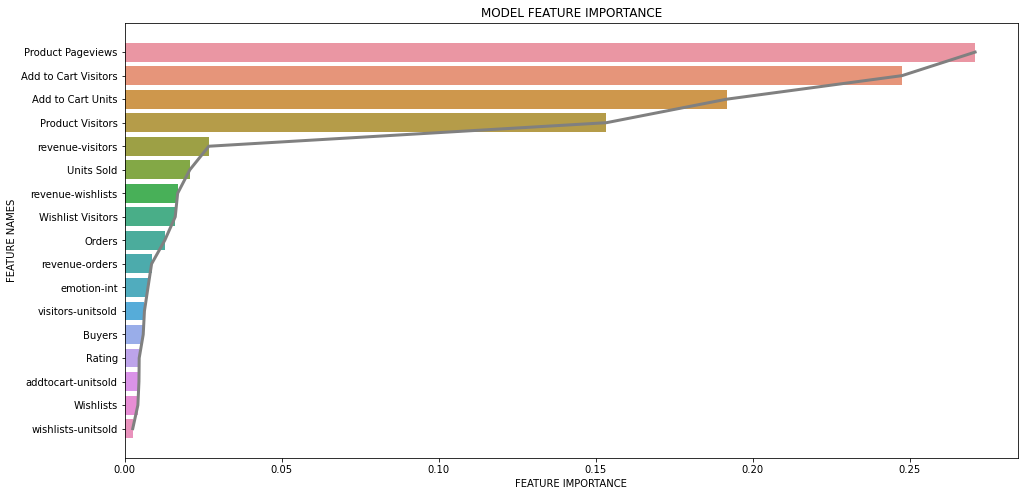

In [32]:
# Get feature importance 
#Function plots bar and line plot of feature importance 
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(16,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], orient='h')
    sns.lineplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], color='grey', linewidth=3)
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(rfmodel.feature_importances_, X_train.columns,'MODEL ')

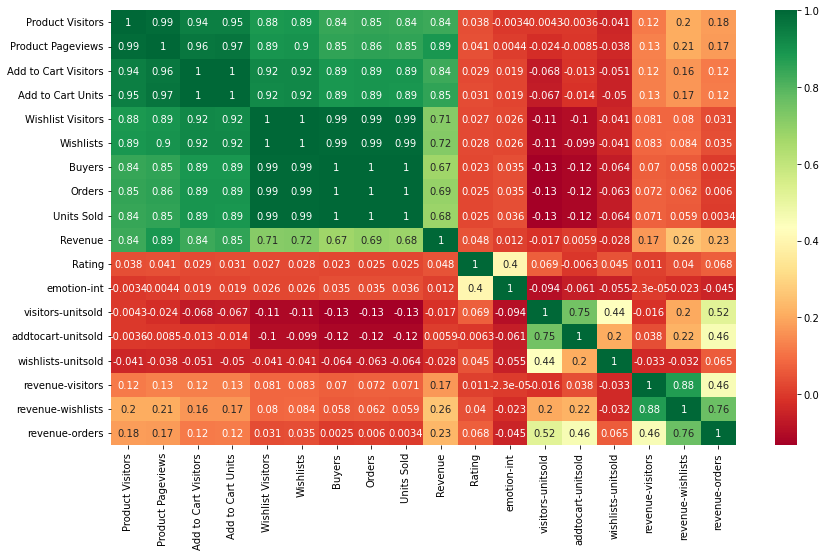

In [33]:
# Get correlations of each features
dfcorr_temp = df.copy()
dfcorr_temp = dfcorr_temp.drop(['Product ID'], axis='columns')
corrmat = dfcorr_temp.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(14,8))

# Plot heat map
g = sns.heatmap(dfcorr_temp[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Best alpha using built-in LassoCV: 351157356622.008911
Best score using built-in LassoCV: 298247773.622349
Lasso picked 5 variables and eliminated the other 12 variables


Text(0.5, 1.0, 'Feature Importance of Model')

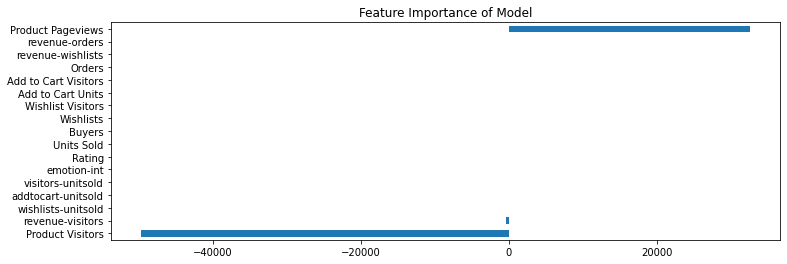

In [34]:
# Feature Selection Using LassoCV
# https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

reg = LassoCV(cv=5, n_alphas=10, random_state=RANDOM_STATE)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" % rmse)

coef = pd.Series(reg.coef_, index = X.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

# Plot visualization
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (12, 4)
imp_coef.plot(kind = "barh")
plt.title("Feature Importance of Model")

# 5) Model Evaluation

In [35]:
# Random Forest Model w feature engineering
final_cols_to_use = ['Product Visitors', 'Product Pageviews', 'revenue-orders', 'revenue-visitors', 'addtocart-unitsold', 'emotion-int']
X = df[final_cols_to_use]
y = df['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

# Pipeline for scaling and model
pipeline = Pipeline([
    ("MinMax Scaling", MinMaxScaler()), # Scaling
    ("RFmodel", RandomForestRegressor(n_estimators=100, max_depth=7)) 
])

pipeline.fit(X_train, y_train)

# Train the model on training data
print('R-squared score (training): {:.3f}'
     .format(pipeline.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(pipeline.score(X_test, y_test)))

# Predict new data with trained model
y_pred = pipeline.predict(X_test)
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
print('Root Mean Squared Error (RMSE):{:.0f}'.format(rmse))


R-squared score (training): 0.978
R-squared score (test): 0.776
Root Mean Squared Error (RMSE):171051855


In [ ]:
# Best Model - XGBoost RF w feature engineering
final_cols_to_use = ['Product Visitors', 'Product Pageviews', 'revenue-orders', 'revenue-visitors', 'addtocart-unitsold', 'emotion-int']
X = df[final_cols_to_use]
y = df['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

pipeline = Pipeline([
    ("MinMax Scaling", MinMaxScaler()),
    ("XGmodel", XGBRegressor(n_estimators=1000, max_depth=7, learning_rate = 0.1))
])

pipeline.fit(X_train, y_train)

# Train the model on training data
print('R-squared score (training): {:.3f}'
     .format(pipeline.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(pipeline.score(X_test, y_test)))

# Predict new data with trained model
y_pred = pipeline.predict(X_test)
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
print('Root Mean Squared Error (RMSE):{:.0f}'.format(rmse))


[13:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R-squared score (training): 1.000
R-squared score (test): 0.868
Root Mean Squared Error (RMSE):131084379


# 6) Hyperparameter Tuning

In [49]:
# Hyperparameter tuning using Optuna
def objective(trial):

      final_cols_to_use = ['Product Visitors', 'Product Pageviews', 'revenue-orders', 'revenue-visitors', 'addtocart-unitsold', 'emotion-int']
      X = df[final_cols_to_use]
      y = df['Revenue']
      X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

      # Define scaler
      scaler = MinMaxScaler()
    
      # Define hyperparameters
      n_estimators = trial.suggest_int('n_estimators', 1, 500)
      max_depth = trial.suggest_int('max_depth', 3, 15)
      learning_rate = trial.suggest_float('learning_rate', 0.0, 0.5, step=0.02)
      gamma = trial.suggest_float('gamma', 0, 1, step=0.1)

      # Train and evaluate
      model = XGBRegressor(
          n_estimators=n_estimators, 
          max_depth=max_depth,
          learning_rate=learning_rate,
          gamma=gamma,
          subsample=1,
          colsample_bytree=1,
          max_delta_step=0,
          random_state=RANDOM_STATE)
      
      # Make a pipeline
      pipeline = make_pipeline(scaler, model)
      
      # Evaluation
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
      return rmse


study = optuna.create_study(
              direction='minimize', 
              pruner=optuna.pruners.MedianPruner())
study.optimize(objective, 
               n_trials=100, 
               show_progress_bar=True)

trial = study.best_trial
print('Best RMSE: {}'.format(trial.value), " | Best hyperparameters: {}".format(trial.params))

[I 2022-08-17 22:47:30,519] A new study created in memory with name: no-name-400e8cf2-b34c-4030-b6c7-d6debf91f153
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
  1%|          | 1/100 [00:00<00:21,  4.69it/s]

[I 2022-08-17 22:47:30,734] Trial 0 finished with value: 121361891.10540862 and parameters: {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.46, 'gamma': 0.8}. Best is trial 0 with value: 121361891.10540862.


  2%|▏         | 2/100 [00:00<00:27,  3.52it/s]

[I 2022-08-17 22:47:31,068] Trial 1 finished with value: 116075075.98871343 and parameters: {'n_estimators': 354, 'max_depth': 11, 'learning_rate': 0.22, 'gamma': 0.9}. Best is trial 1 with value: 116075075.98871343.


  3%|▎         | 3/100 [00:00<00:27,  3.59it/s]

[I 2022-08-17 22:47:31,340] Trial 2 finished with value: 121362247.78827596 and parameters: {'n_estimators': 438, 'max_depth': 3, 'learning_rate': 0.46, 'gamma': 0.8}. Best is trial 1 with value: 116075075.98871343.


  4%|▍         | 4/100 [00:01<00:34,  2.79it/s]

[I 2022-08-17 22:47:31,819] Trial 3 finished with value: 139621652.2784866 and parameters: {'n_estimators': 272, 'max_depth': 15, 'learning_rate': 0.04, 'gamma': 0.4}. Best is trial 1 with value: 116075075.98871343.


  5%|▌         | 5/100 [00:01<00:35,  2.69it/s]

[I 2022-08-17 22:47:32,215] Trial 4 finished with value: 121302156.12219813 and parameters: {'n_estimators': 339, 'max_depth': 12, 'learning_rate': 0.24, 'gamma': 1.0}. Best is trial 1 with value: 116075075.98871343.


  6%|▌         | 6/100 [00:02<00:34,  2.69it/s]

[I 2022-08-17 22:47:32,585] Trial 5 finished with value: 116010475.05732474 and parameters: {'n_estimators': 332, 'max_depth': 11, 'learning_rate': 0.2, 'gamma': 0.8}. Best is trial 5 with value: 116010475.05732474.


  7%|▋         | 7/100 [00:02<00:31,  2.91it/s]

[I 2022-08-17 22:47:32,873] Trial 6 finished with value: 110848211.62201522 and parameters: {'n_estimators': 221, 'max_depth': 15, 'learning_rate': 0.32, 'gamma': 0.5}. Best is trial 6 with value: 110848211.62201522.


  8%|▊         | 8/100 [00:02<00:27,  3.37it/s]

[I 2022-08-17 22:47:33,069] Trial 7 finished with value: 150218331.84528092 and parameters: {'n_estimators': 138, 'max_depth': 15, 'learning_rate': 0.14, 'gamma': 0.8}. Best is trial 6 with value: 110848211.62201522.


  9%|▉         | 9/100 [00:02<00:25,  3.63it/s]

[I 2022-08-17 22:47:33,297] Trial 8 finished with value: 114558896.81100522 and parameters: {'n_estimators': 388, 'max_depth': 5, 'learning_rate': 0.34, 'gamma': 0.9}. Best is trial 6 with value: 110848211.62201522.


 12%|█▏        | 12/100 [00:03<00:15,  5.80it/s]

[I 2022-08-17 22:47:33,534] Trial 9 finished with value: 121322796.6441593 and parameters: {'n_estimators': 257, 'max_depth': 8, 'learning_rate': 0.24, 'gamma': 1.0}. Best is trial 6 with value: 110848211.62201522.
[I 2022-08-17 22:47:33,563] Trial 10 finished with value: 114842847.00264011 and parameters: {'n_estimators': 12, 'max_depth': 8, 'learning_rate': 0.34, 'gamma': 0.1}. Best is trial 6 with value: 110848211.62201522.
[I 2022-08-17 22:47:33,672] Trial 11 finished with value: 136499840.65252265 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.36, 'gamma': 0.5}. Best is trial 6 with value: 110848211.62201522.


 13%|█▎        | 13/100 [00:03<00:14,  6.19it/s]

[I 2022-08-17 22:47:33,801] Trial 12 finished with value: 136499716.5062271 and parameters: {'n_estimators': 165, 'max_depth': 6, 'learning_rate': 0.36, 'gamma': 0.30000000000000004}. Best is trial 6 with value: 110848211.62201522.


 14%|█▍        | 14/100 [00:03<00:15,  5.49it/s]

[I 2022-08-17 22:47:34,041] Trial 13 finished with value: 111745005.9928924 and parameters: {'n_estimators': 423, 'max_depth': 5, 'learning_rate': 0.32, 'gamma': 0.6000000000000001}. Best is trial 6 with value: 110848211.62201522.


 17%|█▋        | 17/100 [00:03<00:12,  6.56it/s]

[I 2022-08-17 22:47:34,337] Trial 14 finished with value: 113561666.92224078 and parameters: {'n_estimators': 216, 'max_depth': 13, 'learning_rate': 0.3, 'gamma': 0.6000000000000001}. Best is trial 6 with value: 110848211.62201522.
[I 2022-08-17 22:47:34,435] Trial 15 finished with value: 107299333.91213182 and parameters: {'n_estimators': 61, 'max_depth': 9, 'learning_rate': 0.42, 'gamma': 0.6000000000000001}. Best is trial 15 with value: 107299333.91213182.
[I 2022-08-17 22:47:34,486] Trial 16 finished with value: 92619320.7885392 and parameters: {'n_estimators': 33, 'max_depth': 9, 'learning_rate': 0.5, 'gamma': 0.2}. Best is trial 16 with value: 92619320.7885392.
[I 2022-08-17 22:47:34,508] Trial 17 finished with value: 138157278.7361555 and parameters: {'n_estimators': 2, 'max_depth': 9, 'learning_rate': 0.5, 'gamma': 0.1}. Best is trial 16 with value: 92619320.7885392.


 19%|█▉        | 19/100 [00:04<00:09,  8.58it/s]

[I 2022-08-17 22:47:34,605] Trial 18 finished with value: 107027631.19990455 and parameters: {'n_estimators': 71, 'max_depth': 10, 'learning_rate': 0.4, 'gamma': 0.0}. Best is trial 16 with value: 92619320.7885392.
[I 2022-08-17 22:47:34,729] Trial 19 finished with value: 106485576.20702137 and parameters: {'n_estimators': 88, 'max_depth': 10, 'learning_rate': 0.42, 'gamma': 0.0}. Best is trial 16 with value: 92619320.7885392.


 22%|██▏       | 22/100 [00:04<00:09,  8.20it/s]

[I 2022-08-17 22:47:34,894] Trial 20 finished with value: 139623449.47955662 and parameters: {'n_estimators': 95, 'max_depth': 13, 'learning_rate': 0.46, 'gamma': 0.2}. Best is trial 16 with value: 92619320.7885392.
[I 2022-08-17 22:47:34,998] Trial 21 finished with value: 107027489.59619905 and parameters: {'n_estimators': 68, 'max_depth': 10, 'learning_rate': 0.4, 'gamma': 0.0}. Best is trial 16 with value: 92619320.7885392.
[I 2022-08-17 22:47:35,057] Trial 22 finished with value: 92219603.83631924 and parameters: {'n_estimators': 43, 'max_depth': 8, 'learning_rate': 0.5, 'gamma': 0.0}. Best is trial 22 with value: 92219603.83631924.


 27%|██▋       | 27/100 [00:04<00:06, 12.02it/s]

[I 2022-08-17 22:47:35,169] Trial 23 finished with value: 95738656.65999472 and parameters: {'n_estimators': 112, 'max_depth': 7, 'learning_rate': 0.5, 'gamma': 0.2}. Best is trial 22 with value: 92219603.83631924.
[I 2022-08-17 22:47:35,219] Trial 24 finished with value: 95698352.76121081 and parameters: {'n_estimators': 33, 'max_depth': 7, 'learning_rate': 0.5, 'gamma': 0.2}. Best is trial 22 with value: 92219603.83631924.
[I 2022-08-17 22:47:35,266] Trial 25 finished with value: 116187130.24888524 and parameters: {'n_estimators': 33, 'max_depth': 7, 'learning_rate': 0.48, 'gamma': 0.2}. Best is trial 22 with value: 92219603.83631924.
[I 2022-08-17 22:47:35,322] Trial 26 finished with value: 387808268.1365013 and parameters: {'n_estimators': 39, 'max_depth': 8, 'learning_rate': 0.0, 'gamma': 0.30000000000000004}. Best is trial 22 with value: 92219603.83631924.


 29%|██▉       | 29/100 [00:05<00:06, 10.60it/s]

[I 2022-08-17 22:47:35,436] Trial 27 finished with value: 109970059.57788005 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.44, 'gamma': 0.1}. Best is trial 22 with value: 92219603.83631924.
[I 2022-08-17 22:47:35,563] Trial 28 finished with value: 92016327.9757978 and parameters: {'n_estimators': 184, 'max_depth': 5, 'learning_rate': 0.5, 'gamma': 0.30000000000000004}. Best is trial 28 with value: 92016327.9757978.


 31%|███       | 31/100 [00:05<00:07,  9.53it/s]

[I 2022-08-17 22:47:35,655] Trial 29 finished with value: 118745726.92561388 and parameters: {'n_estimators': 194, 'max_depth': 3, 'learning_rate': 0.14, 'gamma': 0.30000000000000004}. Best is trial 28 with value: 92016327.9757978.
[I 2022-08-17 22:47:35,824] Trial 30 finished with value: 111259315.67445494 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.38, 'gamma': 0.4}. Best is trial 28 with value: 92016327.9757978.


 33%|███▎      | 33/100 [00:05<00:06,  9.79it/s]

[I 2022-08-17 22:47:35,871] Trial 31 finished with value: 92360110.4249197 and parameters: {'n_estimators': 39, 'max_depth': 6, 'learning_rate': 0.5, 'gamma': 0.1}. Best is trial 28 with value: 92016327.9757978.
[I 2022-08-17 22:47:36,015] Trial 32 finished with value: 146527243.73066315 and parameters: {'n_estimators': 174, 'max_depth': 5, 'learning_rate': 0.46, 'gamma': 0.1}. Best is trial 28 with value: 92016327.9757978.
[I 2022-08-17 22:47:36,045] Trial 33 finished with value: 248552391.8441476 and parameters: {'n_estimators': 1, 'max_depth': 6, 'learning_rate': 0.44, 'gamma': 0.0}. Best is trial 28 with value: 92016327.9757978.


 35%|███▌      | 35/100 [00:05<00:06, 10.10it/s]

[I 2022-08-17 22:47:36,198] Trial 34 finished with value: 92216992.74739902 and parameters: {'n_estimators': 105, 'max_depth': 8, 'learning_rate': 0.5, 'gamma': 0.4}. Best is trial 28 with value: 92016327.9757978.
[I 2022-08-17 22:47:36,297] Trial 35 finished with value: 105959112.55223887 and parameters: {'n_estimators': 111, 'max_depth': 4, 'learning_rate': 0.46, 'gamma': 0.4}. Best is trial 28 with value: 92016327.9757978.


 37%|███▋      | 37/100 [00:05<00:06,  9.89it/s]

[I 2022-08-17 22:47:36,410] Trial 36 finished with value: 117305001.65386206 and parameters: {'n_estimators': 191, 'max_depth': 4, 'learning_rate': 0.48, 'gamma': 0.4}. Best is trial 28 with value: 92016327.9757978.
[I 2022-08-17 22:47:36,492] Trial 37 finished with value: 107382473.75577588 and parameters: {'n_estimators': 95, 'max_depth': 6, 'learning_rate': 0.42, 'gamma': 0.30000000000000004}. Best is trial 28 with value: 92016327.9757978.


 39%|███▉      | 39/100 [00:06<00:06,  9.80it/s]

[I 2022-08-17 22:47:36,619] Trial 38 finished with value: 117735606.51119979 and parameters: {'n_estimators': 139, 'max_depth': 8, 'learning_rate': 0.28, 'gamma': 0.1}. Best is trial 28 with value: 92016327.9757978.
[I 2022-08-17 22:47:36,751] Trial 39 finished with value: 128071521.46179031 and parameters: {'n_estimators': 225, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.4}. Best is trial 28 with value: 92016327.9757978.


 43%|████▎     | 43/100 [00:06<00:05, 11.19it/s]

[I 2022-08-17 22:47:36,842] Trial 40 finished with value: 116702383.77493349 and parameters: {'n_estimators': 63, 'max_depth': 11, 'learning_rate': 0.48, 'gamma': 0.7000000000000001}. Best is trial 28 with value: 92016327.9757978.
[I 2022-08-17 22:47:36,908] Trial 41 finished with value: 92623692.21970828 and parameters: {'n_estimators': 44, 'max_depth': 9, 'learning_rate': 0.5, 'gamma': 0.2}. Best is trial 28 with value: 92016327.9757978.
[I 2022-08-17 22:47:36,948] Trial 42 finished with value: 108661615.48032841 and parameters: {'n_estimators': 28, 'max_depth': 8, 'learning_rate': 0.44, 'gamma': 0.30000000000000004}. Best is trial 28 with value: 92016327.9757978.


 43%|████▎     | 43/100 [00:06<00:05, 11.19it/s]

[I 2022-08-17 22:47:37,069] Trial 43 finished with value: 116540749.87790236 and parameters: {'n_estimators': 89, 'max_depth': 9, 'learning_rate': 0.48, 'gamma': 0.1}. Best is trial 28 with value: 92016327.9757978.


 47%|████▋     | 47/100 [00:07<00:07,  7.49it/s]

[I 2022-08-17 22:47:37,552] Trial 44 finished with value: 116100943.99611816 and parameters: {'n_estimators': 490, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.2}. Best is trial 28 with value: 92016327.9757978.
[I 2022-08-17 22:47:37,639] Trial 45 finished with value: 140412595.87386253 and parameters: {'n_estimators': 62, 'max_depth': 6, 'learning_rate': 0.46, 'gamma': 0.5}. Best is trial 28 with value: 92016327.9757978.
[I 2022-08-17 22:47:37,727] Trial 46 finished with value: 88522813.31675394 and parameters: {'n_estimators': 158, 'max_depth': 3, 'learning_rate': 0.5, 'gamma': 0.0}. Best is trial 46 with value: 88522813.31675394.


 48%|████▊     | 48/100 [00:07<00:06,  7.49it/s]

[I 2022-08-17 22:47:37,831] Trial 47 finished with value: 97051896.04070942 and parameters: {'n_estimators': 151, 'max_depth': 3, 'learning_rate': 0.4, 'gamma': 0.0}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:38,018] Trial 48 finished with value: 115803212.51290664 and parameters: {'n_estimators': 241, 'max_depth': 4, 'learning_rate': 0.44, 'gamma': 0.0}. Best is trial 46 with value: 88522813.31675394.


 51%|█████     | 51/100 [00:07<00:06,  7.24it/s]

[I 2022-08-17 22:47:38,181] Trial 49 finished with value: 132974391.8840127 and parameters: {'n_estimators': 272, 'max_depth': 3, 'learning_rate': 0.48, 'gamma': 0.1}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:38,305] Trial 50 finished with value: 109568204.4549594 and parameters: {'n_estimators': 169, 'max_depth': 5, 'learning_rate': 0.38, 'gamma': 0.5}. Best is trial 46 with value: 88522813.31675394.


 53%|█████▎    | 53/100 [00:08<00:06,  6.84it/s]

[I 2022-08-17 22:47:38,445] Trial 51 finished with value: 92216991.96249764 and parameters: {'n_estimators': 120, 'max_depth': 8, 'learning_rate': 0.5, 'gamma': 0.1}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:38,615] Trial 52 finished with value: 92332976.270176 and parameters: {'n_estimators': 185, 'max_depth': 6, 'learning_rate': 0.5, 'gamma': 0.0}. Best is trial 46 with value: 88522813.31675394.


 55%|█████▌    | 55/100 [00:08<00:06,  6.79it/s]

[I 2022-08-17 22:47:38,801] Trial 53 finished with value: 139626140.3970065 and parameters: {'n_estimators': 197, 'max_depth': 8, 'learning_rate': 0.46, 'gamma': 0.0}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:38,924] Trial 54 finished with value: 92216993.06004265 and parameters: {'n_estimators': 123, 'max_depth': 8, 'learning_rate': 0.5, 'gamma': 0.0}. Best is trial 46 with value: 88522813.31675394.


 56%|█████▌    | 56/100 [00:08<00:06,  6.91it/s]

[I 2022-08-17 22:47:39,062] Trial 55 finished with value: 116791994.56928964 and parameters: {'n_estimators': 122, 'max_depth': 10, 'learning_rate': 0.48, 'gamma': 0.1}. Best is trial 46 with value: 88522813.31675394.


 58%|█████▊    | 58/100 [00:08<00:06,  6.64it/s]

[I 2022-08-17 22:47:39,240] Trial 56 finished with value: 108207126.47796904 and parameters: {'n_estimators': 153, 'max_depth': 11, 'learning_rate': 0.44, 'gamma': 0.0}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:39,381] Trial 57 finished with value: 107299133.16996661 and parameters: {'n_estimators': 134, 'max_depth': 9, 'learning_rate': 0.42, 'gamma': 0.0}. Best is trial 46 with value: 88522813.31675394.


 60%|██████    | 60/100 [00:09<00:05,  7.36it/s]

[I 2022-08-17 22:47:39,500] Trial 58 finished with value: 92216992.6630025 and parameters: {'n_estimators': 106, 'max_depth': 8, 'learning_rate': 0.5, 'gamma': 0.1}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:39,623] Trial 59 finished with value: 116114612.50762254 and parameters: {'n_estimators': 110, 'max_depth': 7, 'learning_rate': 0.48, 'gamma': 0.30000000000000004}. Best is trial 46 with value: 88522813.31675394.


 62%|██████▏   | 62/100 [00:09<00:06,  6.31it/s]

[I 2022-08-17 22:47:39,907] Trial 60 finished with value: 139630732.0552042 and parameters: {'n_estimators': 209, 'max_depth': 14, 'learning_rate': 0.46, 'gamma': 0.2}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:40,016] Trial 61 finished with value: 92216982.73718381 and parameters: {'n_estimators': 81, 'max_depth': 8, 'learning_rate': 0.5, 'gamma': 0.1}. Best is trial 46 with value: 88522813.31675394.


 64%|██████▍   | 64/100 [00:09<00:04,  7.54it/s]

[I 2022-08-17 22:47:40,107] Trial 62 finished with value: 92216976.46475592 and parameters: {'n_estimators': 84, 'max_depth': 8, 'learning_rate': 0.5, 'gamma': 0.1}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:40,220] Trial 63 finished with value: 116791978.98100209 and parameters: {'n_estimators': 82, 'max_depth': 10, 'learning_rate': 0.48, 'gamma': 0.1}. Best is trial 46 with value: 88522813.31675394.


 65%|██████▌   | 65/100 [00:09<00:04,  7.73it/s]

[I 2022-08-17 22:47:40,339] Trial 64 finished with value: 139551379.2353574 and parameters: {'n_estimators': 101, 'max_depth': 9, 'learning_rate': 0.46, 'gamma': 0.2}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:40,425] Trial 65 finished with value: 95738273.18555339 and parameters: {'n_estimators': 77, 'max_depth': 7, 'learning_rate': 0.5, 'gamma': 0.1}. Best is trial 46 with value: 88522813.31675394.


 68%|██████▊   | 68/100 [00:10<00:03,  8.15it/s]

[I 2022-08-17 22:47:40,564] Trial 66 finished with value: 107328209.8005274 and parameters: {'n_estimators': 155, 'max_depth': 8, 'learning_rate': 0.42, 'gamma': 0.5}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:40,688] Trial 67 finished with value: 109970081.18721698 and parameters: {'n_estimators': 141, 'max_depth': 7, 'learning_rate': 0.44, 'gamma': 0.2}. Best is trial 46 with value: 88522813.31675394.


 70%|███████   | 70/100 [00:10<00:03,  7.90it/s]

[I 2022-08-17 22:47:40,831] Trial 68 finished with value: 93000004.6191094 and parameters: {'n_estimators': 107, 'max_depth': 12, 'learning_rate': 0.5, 'gamma': 0.30000000000000004}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:40,955] Trial 69 finished with value: 116540746.51174913 and parameters: {'n_estimators': 125, 'max_depth': 9, 'learning_rate': 0.48, 'gamma': 0.1}. Best is trial 46 with value: 88522813.31675394.


 72%|███████▏  | 72/100 [00:10<00:03,  8.96it/s]

[I 2022-08-17 22:47:41,019] Trial 70 finished with value: 107571358.89508103 and parameters: {'n_estimators': 56, 'max_depth': 8, 'learning_rate': 0.4, 'gamma': 0.4}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:41,137] Trial 71 finished with value: 92216991.83025415 and parameters: {'n_estimators': 121, 'max_depth': 8, 'learning_rate': 0.5, 'gamma': 0.1}. Best is trial 46 with value: 88522813.31675394.


 74%|███████▍  | 74/100 [00:10<00:03,  7.48it/s]

[I 2022-08-17 22:47:41,306] Trial 72 finished with value: 92216988.6021104 and parameters: {'n_estimators': 162, 'max_depth': 8, 'learning_rate': 0.5, 'gamma': 0.1}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:41,466] Trial 73 finished with value: 137183148.76776963 and parameters: {'n_estimators': 178, 'max_depth': 7, 'learning_rate': 0.46, 'gamma': 0.1}. Best is trial 46 with value: 88522813.31675394.


 76%|███████▌  | 76/100 [00:11<00:03,  6.74it/s]

[I 2022-08-17 22:47:41,648] Trial 74 finished with value: 120857995.30443448 and parameters: {'n_estimators': 170, 'max_depth': 9, 'learning_rate': 0.26, 'gamma': 0.2}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:41,803] Trial 75 finished with value: 116301435.9376543 and parameters: {'n_estimators': 160, 'max_depth': 8, 'learning_rate': 0.48, 'gamma': 0.1}. Best is trial 46 with value: 88522813.31675394.


 78%|███████▊  | 78/100 [00:11<00:03,  7.32it/s]

[I 2022-08-17 22:47:41,918] Trial 76 finished with value: 92017142.9620226 and parameters: {'n_estimators': 139, 'max_depth': 5, 'learning_rate': 0.5, 'gamma': 0.1}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:42,049] Trial 77 finished with value: 146527190.58612406 and parameters: {'n_estimators': 205, 'max_depth': 5, 'learning_rate': 0.46, 'gamma': 0.0}. Best is trial 46 with value: 88522813.31675394.


 80%|████████  | 80/100 [00:11<00:02,  8.16it/s]

[I 2022-08-17 22:47:42,127] Trial 78 finished with value: 103042797.71267879 and parameters: {'n_estimators': 142, 'max_depth': 3, 'learning_rate': 0.44, 'gamma': 0.2}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:42,258] Trial 79 finished with value: 90142872.1021661 and parameters: {'n_estimators': 235, 'max_depth': 4, 'learning_rate': 0.5, 'gamma': 0.1}. Best is trial 46 with value: 88522813.31675394.


 82%|████████▏ | 82/100 [00:12<00:02,  7.34it/s]

[I 2022-08-17 22:47:42,395] Trial 80 finished with value: 117305247.91226068 and parameters: {'n_estimators': 225, 'max_depth': 4, 'learning_rate': 0.48, 'gamma': 0.1}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:42,560] Trial 81 finished with value: 90142484.97194384 and parameters: {'n_estimators': 320, 'max_depth': 4, 'learning_rate': 0.5, 'gamma': 0.1}. Best is trial 46 with value: 88522813.31675394.


 84%|████████▍ | 84/100 [00:12<00:02,  6.36it/s]

[I 2022-08-17 22:47:42,741] Trial 82 finished with value: 90142471.68793903 and parameters: {'n_estimators': 341, 'max_depth': 4, 'learning_rate': 0.5, 'gamma': 0.1}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:42,922] Trial 83 finished with value: 117304370.98599741 and parameters: {'n_estimators': 358, 'max_depth': 4, 'learning_rate': 0.48, 'gamma': 0.9}. Best is trial 46 with value: 88522813.31675394.


 85%|████████▌ | 85/100 [00:12<00:02,  6.54it/s]

[I 2022-08-17 22:47:43,065] Trial 84 finished with value: 113418917.73169391 and parameters: {'n_estimators': 322, 'max_depth': 3, 'learning_rate': 0.12, 'gamma': 0.0}. Best is trial 46 with value: 88522813.31675394.


 87%|████████▋ | 87/100 [00:12<00:02,  6.09it/s]

[I 2022-08-17 22:47:43,271] Trial 85 finished with value: 118106407.67028925 and parameters: {'n_estimators': 391, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0.2}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:43,424] Trial 86 finished with value: 136809028.76639318 and parameters: {'n_estimators': 285, 'max_depth': 4, 'learning_rate': 0.06, 'gamma': 0.1}. Best is trial 46 with value: 88522813.31675394.


 89%|████████▉ | 89/100 [00:13<00:01,  6.48it/s]

[I 2022-08-17 22:47:43,580] Trial 87 finished with value: 146527165.81463897 and parameters: {'n_estimators': 251, 'max_depth': 5, 'learning_rate': 0.46, 'gamma': 1.0}. Best is trial 46 with value: 88522813.31675394.
[I 2022-08-17 22:47:43,717] Trial 88 finished with value: 88461060.12253188 and parameters: {'n_estimators': 317, 'max_depth': 3, 'learning_rate': 0.5, 'gamma': 0.0}. Best is trial 88 with value: 88461060.12253188.


 90%|█████████ | 90/100 [00:13<00:01,  6.56it/s]

[I 2022-08-17 22:47:43,865] Trial 89 finished with value: 132974793.62659094 and parameters: {'n_estimators': 324, 'max_depth': 3, 'learning_rate': 0.48, 'gamma': 0.0}. Best is trial 88 with value: 88461060.12253188.


 92%|█████████▏| 92/100 [00:13<00:01,  5.83it/s]

[I 2022-08-17 22:47:44,073] Trial 90 finished with value: 114732134.20703655 and parameters: {'n_estimators': 362, 'max_depth': 5, 'learning_rate': 0.44, 'gamma': 0.0}. Best is trial 88 with value: 88461060.12253188.
[I 2022-08-17 22:47:44,250] Trial 91 finished with value: 90142458.75985701 and parameters: {'n_estimators': 343, 'max_depth': 4, 'learning_rate': 0.5, 'gamma': 0.1}. Best is trial 88 with value: 88461060.12253188.


 93%|█████████▎| 93/100 [00:13<00:01,  5.75it/s]

[I 2022-08-17 22:47:44,430] Trial 92 finished with value: 90142459.28340018 and parameters: {'n_estimators': 345, 'max_depth': 4, 'learning_rate': 0.5, 'gamma': 0.0}. Best is trial 88 with value: 88461060.12253188.


 95%|█████████▌| 95/100 [00:14<00:00,  5.70it/s]

[I 2022-08-17 22:47:44,624] Trial 93 finished with value: 117304412.28204568 and parameters: {'n_estimators': 345, 'max_depth': 4, 'learning_rate': 0.48, 'gamma': 0.0}. Best is trial 88 with value: 88461060.12253188.
[I 2022-08-17 22:47:44,789] Trial 94 finished with value: 88456176.01205395 and parameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.5, 'gamma': 0.0}. Best is trial 94 with value: 88456176.01205395.


 97%|█████████▋| 97/100 [00:14<00:00,  6.19it/s]

[I 2022-08-17 22:47:44,960] Trial 95 finished with value: 121361285.47566484 and parameters: {'n_estimators': 382, 'max_depth': 3, 'learning_rate': 0.46, 'gamma': 0.0}. Best is trial 94 with value: 88456176.01205395.
[I 2022-08-17 22:47:45,091] Trial 96 finished with value: 132974847.2144292 and parameters: {'n_estimators': 298, 'max_depth': 3, 'learning_rate': 0.48, 'gamma': 0.0}. Best is trial 94 with value: 88456176.01205395.


 98%|█████████▊| 98/100 [00:14<00:00,  5.87it/s]

[I 2022-08-17 22:47:45,285] Trial 97 finished with value: 90142481.40914118 and parameters: {'n_estimators': 374, 'max_depth': 4, 'learning_rate': 0.5, 'gamma': 0.0}. Best is trial 94 with value: 88456176.01205395.


 99%|█████████▉| 99/100 [00:14<00:00,  5.60it/s]

[I 2022-08-17 22:47:45,481] Trial 98 finished with value: 105970993.7771264 and parameters: {'n_estimators': 372, 'max_depth': 4, 'learning_rate': 0.46, 'gamma': 0.0}. Best is trial 94 with value: 88456176.01205395.


100%|██████████| 100/100 [00:15<00:00,  6.60it/s]

[I 2022-08-17 22:47:45,665] Trial 99 finished with value: 88457626.07693373 and parameters: {'n_estimators': 410, 'max_depth': 3, 'learning_rate': 0.5, 'gamma': 0.0}. Best is trial 94 with value: 88456176.01205395.
Best RMSE: 88456176.01205395  | Best hyperparameters: {'n_estimators': 375, 'max_depth': 3, 'learning_rate': 0.5, 'gamma': 0.0}


In [4]:
optuna.visualization.plot_optimization_history(study)

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

# 7) Saving Final Model

In [51]:
# Final model - XGBoost RF with feature engineering and tuning
final_cols_to_use = ['Product Visitors', 'Product Pageviews', 'revenue-orders', 'revenue-visitors', 'addtocart-unitsold', 'emotion-int']
X = df[final_cols_to_use]
y = df['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

pipeline = Pipeline([
    ("MinMax Scaling", MinMaxScaler()),
    ("XGmodel", XGBRegressor(n_estimators=375, 
                             max_depth=3, 
                             learning_rate = 0.50,
                             gamma=0.0))
])

pipeline.fit(X_train, y_train)

# Train the model on training data
print('R-squared score (training): {:.3f}'.format(pipeline.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'.format(pipeline.score(X_test, y_test)))
# Predict new data with trained model
y_pred = pipeline.predict(X_test)
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
print('Root Mean Squared Error (RMSE):{:.0f}'.format(rmse))


R-squared score (training): 1.000
R-squared score (test): 0.940
Root Mean Squared Error (RMSE):88456176


In [52]:
# Save final model to disk as 'predictive-final-model.sav'

# Uncomment to save model if model has been changed
#filename = 'predictive-final-model.sav'
#pickle.dump(pipeline, open(filename, 'wb'))
#print('Save completed')

Save completed


In [53]:
# Uncomment to load saved model from disk

#loaded_model = pickle.load(open(filename, 'rb'))
#print('Load completed')

Load completed
